## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv("../scaled_dataset.csv")
df.head()

,production,p_per_m2,p_max,panel_area,facade_area,total_panel_area,exploitation_ratio,air_temp_mean,air_temp_max,clearsky_ghi_mean,...,surface_pressure_mean,surface_pressure_min,surface_pressure_max,wind_direction_100m_mean,wind_direction_100m_min,wind_direction_100m_max,wind_speed_100m_mean,wind_speed_100m_min,wind_speed_100m_max,building_id
0,0.8,143.0,210,1.72,218.0,94.6,0.434,6.255319,7,61.340426,...,1031.902128,1030.8,1034.5,256.340426,227,312,5.036170,2.2,7.4,1
1,16.9,143.0,210,1.72,218.0,94.6,0.434,3.375000,5,59.520833,...,1034.843750,1031.6,1038.1,317.437500,294,339,6.245833,2.0,7.6,1
2,1.4,143.0,210,1.72,218.0,94.6,0.434,-0.666667,2,59.916667,...,1038.256250,1037.5,1039.3,290.979167,211,345,2.154167,1.1,3.5,1
3,6.6,143.0,210,1.72,218.0,94.6,0.434,1.083333,3,63.166667,...,1037.075000,1035.6,1038.6,227.041667,2,359,2.637500,0.6,4.6,1
4,0.3,143.0,210,1.72,218.0,94.6,0.434,2.479167,4,60.812500,...,1032.722917,1031.7,1035.6,259.770833,236,287,5.212500,3.7,6.2,1


## Preoaring the (x,y) pairs

### Scaling the data

In [2]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

### Creating windows

In [3]:
production_column = 'production'

def get_target_column_index(df, target_column):
    for i, column in enumerate(df.columns):
        if column == target_column:
            return i

    return -1

In [4]:
import numpy as np

def get_windows(data, window_size=10):
    x = []
    y = []

    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i][get_target_column_index(df, production_column)])

    return np.array(x), np.array(y)

In [5]:
window_size = 2*12  # 2*1h window
x, y = get_windows(data_scaled, window_size=window_size)

x.shape, y.shape

((10847, 24, 35), (10847,))

### Splitting the data

In [6]:
train_split_index = int(0.8 * len(df))
test_split_index = int(0.9 * len(df))

x_train, y_train = x[:train_split_index], y[:train_split_index]
x_test, y_test = x[train_split_index:test_split_index], y[train_split_index:test_split_index]
x_val, y_val = x[test_split_index:], y[test_split_index:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((8696, 24, 35), (8696,), (1087, 24, 35), (1087,), (1064, 24, 35), (1064,))

### Plotting the splits

In [7]:
import matplotlib.pyplot as plt


def plot_time_series(timesteps, values, label, format='-^', start=0, end=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("date")
    plt.ylabel("production")

    plt.legend(fontsize=14)
    plt.grid(True)

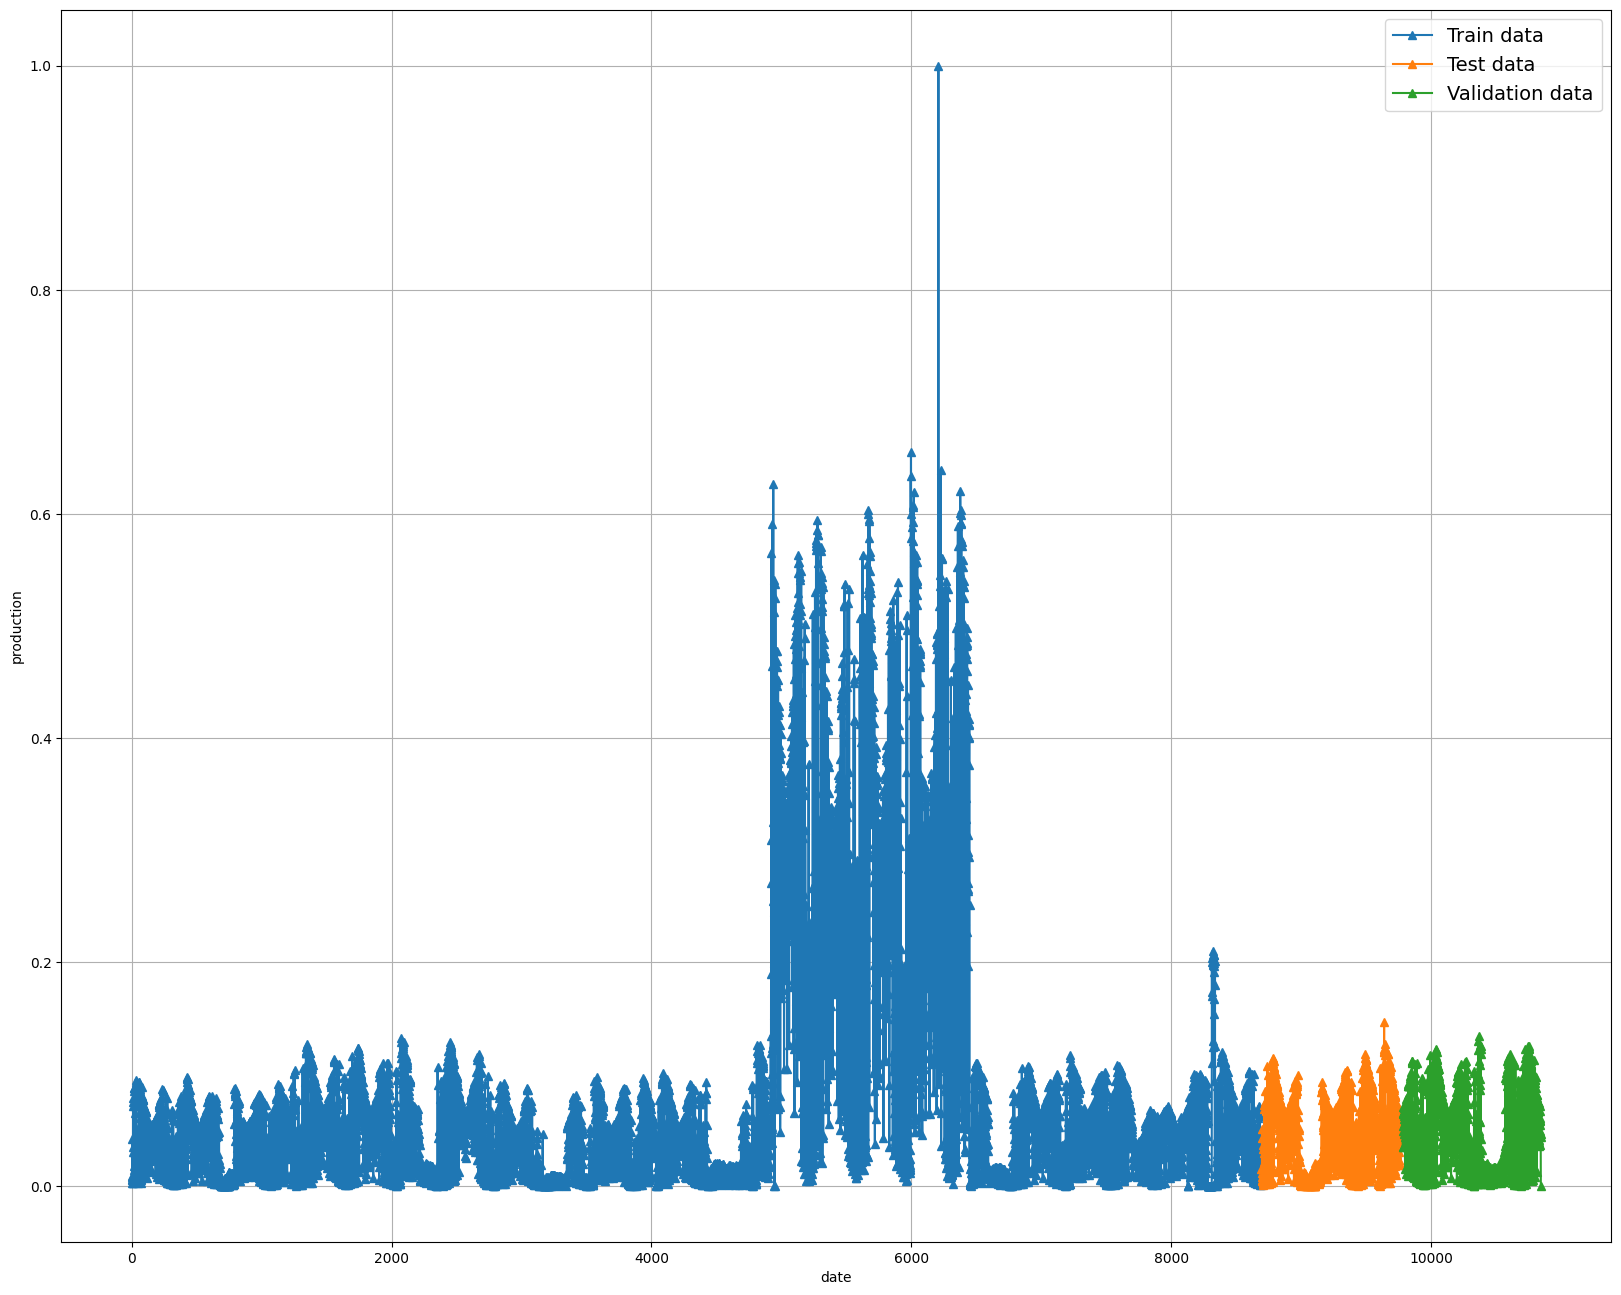

In [8]:
plt.figure(figsize=(20, 16))

timesteps = range(len(x_train))
plot_time_series(timesteps=timesteps, values=y_train, label="Train data")

timesteps = range(len(x_train), len(x_train) + len(x_test))
plot_time_series(timesteps=timesteps, values=y_test, label="Test data")

timesteps = range(len(x_train) + len(x_test),
                  len(x_train) + len(x_test) + len(x_val))
plot_time_series(timesteps=timesteps, values=y_val, label="Validation data")

### Preparing the performances metrics

In [9]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [10]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [11]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()

    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)

    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    r2 = r2_score(y_true.numpy(), y_pred.numpy())  # Assure-toi que y_true et y_pred sont des numpy arrays

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2
    }

## Modeling

In [12]:
import os
import tensorflow as tf

from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM1D, MaxPool1D, GlobalMaxPool1D, Conv1D, Conv2D
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

### Plotting the loss

In [13]:
def plot_loss(history):
    plt.figure(figsize=(20, 8))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Creating callbacks

In [14]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)


def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

### Utils function

In [15]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

## ConvLSTM

#### Preparing the model

In [16]:
x_train_conv_lstm = np.expand_dims(x_train, axis=2)
x_val_conv_lstm = np.expand_dims(x_val, axis=2)
x_test_conv_lstm = np.expand_dims(x_test, axis=2)

print(f"{x_train.shape} -> {x_train_conv_lstm.shape}")

(8696, 24, 35) -> (8696, 24, 1, 35)


In [17]:
tf.random.set_seed(42)

input_shape = (x_train_conv_lstm.shape[1:])
conv_lstm_model = tf.keras.Sequential([
    ConvLSTM1D(filters=128, kernel_size=(1,), activation='tanh',
               return_sequences=True, input_shape=input_shape),
    ConvLSTM1D(filters=64, kernel_size=(1,),
               activation='tanh', return_sequences=False),
    Flatten(),
    Dense(units=64, activation='tanh'),
    Dense(1, activation="linear")
], name="model_conv_lstm.keras")

conv_lstm_model.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0013265066726892468))

conv_lstm_model.summary()

C:\Users\yhoci\blocml\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "model_conv_lstm.keras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm1d (ConvLSTM1D)             │ (None, 24, 1, 128)          │          83,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm1d_1 (ConvLSTM1D)           │ (None, 1, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 137,601 (537.50 KB)

 Trainable params: 137,601 (537.50 KB)

 Non-trainable params: 0 (0.00 B)

#### Training the model convlstm

In [18]:
import os
import time
import logging
from codecarbon import EmissionsTracker


os.makedirs('emissions', exist_ok=True)

tracker_conv_lstm = EmissionsTracker(
    project_name="PEWH",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="emissions_conv_lstm.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon INFO @ 16:56:39] [setup] RAM Tracking...
[codecarbon INFO @ 16:56:39] [setup] CPU Tracking...
[codecarbon WARNING @ 16:56:39] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 16:56:41] We saw that you have a AMD Ryzen 7 7840HS w/ Radeon 780M Graphics but we don't know it. Please contact us.
[codecarbon INFO @ 16:56:41] CPU Model on constant consumption mode: AMD Ryzen 7 7840HS w/ Radeon 780M Graphics
[codecarbon INFO @ 16:56:41] [setup] GPU Tracking...
[codecarbon INFO @ 16:56:41] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:56:41] >>> Tracker's metadata:
[codecarbon INFO @ 16:56:41]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 16:56:41]   Python version: 3.12.3
[codecarbon INFO @ 16:56:41]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 16:56:41]   Available RAM : 15.288 GB
[codecarbon INFO @ 16:56:41]   CPU count: 16
[codecarbon INFO @ 16:

In [19]:
def start_training_conv_lstm():
    start_time = time.time()
    conv_lstm_history = conv_lstm_model.fit(x=x_train_conv_lstm,
                                            y=y_train,
                                            epochs=300,
                                            verbose=1,
                                            batch_size=512,
                                            validation_data=(
                                                x_val_conv_lstm, y_val),
                                            callbacks=[create_model_checkpoint(model_name=conv_lstm_model.name)])
    training_duration = time.time() - start_time

    return conv_lstm_history, training_duration

In [20]:
tracker_conv_lstm.start()
try:
    history_conv_lstm, training_duration_conv_lstm = start_training_conv_lstm()
finally:
    tracker_conv_lstm.stop()

Epoch 1/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - loss: 0.2792 - val_loss: 0.0618
Epoch 2/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0636 - val_loss: 0.0282
Epoch 3/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0461 - val_loss: 0.0282
Epoch 4/300


[codecarbon INFO @ 16:56:51] Energy consumed for RAM : 0.000016 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 16:56:51] Energy consumed for all CPUs : 0.000118 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:56:51] Energy consumed for all GPUs : 0.000012 kWh. Total GPU Power : 4.447358305199286 W
[codecarbon INFO @ 16:56:51] 0.000147 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0426 - val_loss: 0.0275
Epoch 5/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0405 - val_loss: 0.0271
Epoch 6/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0396 - val_loss: 0.0271
Epoch 7/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0392 - val_loss: 0.0274
Epoch 8/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0389 - val_loss: 0.0274
Epoch 9/300
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0390 

[codecarbon INFO @ 16:57:01] Energy consumed for RAM : 0.000032 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 16:57:01] Energy consumed for all CPUs : 0.000237 kWh. Total CPU Power : 42.5 W


13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0390

[codecarbon INFO @ 16:57:01] Energy consumed for all GPUs : 0.000033 kWh. Total GPU Power : 7.536804155427857 W
[codecarbon INFO @ 16:57:01] 0.000302 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0389 - val_loss: 0.0270
Epoch 10/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0386 - val_loss: 0.0259
Epoch 11/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0380 - val_loss: 0.0255
Epoch 12/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0374 - val_loss: 0.0253
Epoch 13/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0372 - val_loss: 0.0247
Epoch 14/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0366 - val_loss: 0.0242
Epoch 15/300
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0361 

[codecarbon INFO @ 16:57:11] Energy consumed for RAM : 0.000048 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 16:57:11] Energy consumed for all CPUs : 0.000355 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:57:11] Energy consumed for all GPUs : 0.000044 kWh. Total GPU Power : 3.9653429065578853 W
[codecarbon INFO @ 16:57:11] 0.000447 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0362 - val_loss: 0.0243
Epoch 16/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0362 - val_loss: 0.0244
Epoch 17/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0352 - val_loss: 0.0234
Epoch 18/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0356 - val_loss: 0.0235
Epoch 19/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0346 - val_loss: 0.0232
Epoch 20/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0349 - val_loss: 0.0233
Epoch 21/300
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0339 

[codecarbon INFO @ 16:57:21] Energy consumed for RAM : 0.000063 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 16:57:21] Energy consumed for all CPUs : 0.000473 kWh. Total CPU Power : 42.5 W


11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0339

[codecarbon INFO @ 16:57:21] Energy consumed for all GPUs : 0.000057 kWh. Total GPU Power : 4.40385362145336 W
[codecarbon INFO @ 16:57:21] 0.000593 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0340 - val_loss: 0.0229
Epoch 22/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0350 - val_loss: 0.0238
Epoch 23/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0334 - val_loss: 0.0230
Epoch 24/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0342 - val_loss: 0.0223
Epoch 25/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0336 - val_loss: 0.0227
Epoch 26/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0329 - val_loss: 0.0219
Epoch 27/300
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0340 

[codecarbon INFO @ 16:57:31] Energy consumed for RAM : 0.000079 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 16:57:31] Energy consumed for all CPUs : 0.000591 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:57:31] Energy consumed for all GPUs : 0.000065 kWh. Total GPU Power : 3.177796929779122 W
[codecarbon INFO @ 16:57:31] 0.000736 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0341 - val_loss: 0.0223
Epoch 28/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0326 - val_loss: 0.0223
Epoch 29/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0325 - val_loss: 0.0227
Epoch 30/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0350 - val_loss: 0.0235
Epoch 31/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0337 - val_loss: 0.0218
Epoch 32/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0323 - val_loss: 0.0226
Epoch 33/300
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0320 

[codecarbon INFO @ 16:57:41] Energy consumed for RAM : 0.000095 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 16:57:41] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:57:41] Energy consumed for all GPUs : 0.000078 kWh. Total GPU Power : 4.6198914132484195 W


13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0320

[codecarbon INFO @ 16:57:41] 0.000883 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0321 - val_loss: 0.0211
Epoch 34/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0319 - val_loss: 0.0227
Epoch 35/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0316 - val_loss: 0.0209
Epoch 36/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0314 - val_loss: 0.0203
Epoch 37/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0319 - val_loss: 0.0206
Epoch 38/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0312 - val_loss: 0.0205
Epoch 39/300
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0319 

[codecarbon INFO @ 16:57:51] Energy consumed for RAM : 0.000111 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 16:57:51] Energy consumed for all CPUs : 0.000827 kWh. Total CPU Power : 42.5 W


14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0319

[codecarbon INFO @ 16:57:51] Energy consumed for all GPUs : 0.000096 kWh. Total GPU Power : 6.518094528724763 W
[codecarbon INFO @ 16:57:51] 0.001035 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0321 - val_loss: 0.0231
Epoch 40/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0328 - val_loss: 0.0217
Epoch 41/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0321 - val_loss: 0.0204
Epoch 42/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0311 - val_loss: 0.0226
Epoch 43/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0308 - val_loss: 0.0195
Epoch 44/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0318 - val_loss: 0.0203
Epoch 45/300
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0320 

[codecarbon INFO @ 16:58:01] Energy consumed for RAM : 0.000127 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 16:58:01] Energy consumed for all CPUs : 0.000945 kWh. Total CPU Power : 42.5 W


14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0320

[codecarbon INFO @ 16:58:01] Energy consumed for all GPUs : 0.000114 kWh. Total GPU Power : 6.448248681047001 W
[codecarbon INFO @ 16:58:01] 0.001187 kWh of electricity used since the beginning.


16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0320

[codecarbon INFO @ 16:58:01] 0.000296 g.CO2eq/s mean an estimation of 9.342176810576687 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0320 - val_loss: 0.0211
Epoch 46/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0313 - val_loss: 0.0199
Epoch 47/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0305 - val_loss: 0.0234
Epoch 48/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0305 - val_loss: 0.0196
Epoch 49/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0309 - val_loss: 0.0202
Epoch 50/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0313 - val_loss: 0.0206
Epoch 51/300
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0309 

[codecarbon INFO @ 16:58:11] Energy consumed for RAM : 0.000143 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 16:58:11] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W


15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0309

[codecarbon INFO @ 16:58:11] Energy consumed for all GPUs : 0.000134 kWh. Total GPU Power : 7.115446160131947 W
[codecarbon INFO @ 16:58:11] 0.001340 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0309 - val_loss: 0.0196
Epoch 52/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0308 - val_loss: 0.0194
Epoch 53/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0309 - val_loss: 0.0202
Epoch 54/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0310 - val_loss: 0.0197
Epoch 55/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0307 - val_loss: 0.0191
Epoch 56/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0301 - val_loss: 0.0228
Epoch 57/300
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0302 

[codecarbon INFO @ 16:58:21] Energy consumed for RAM : 0.000159 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 16:58:21] Energy consumed for all CPUs : 0.001181 kWh. Total CPU Power : 42.5 W


15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0302

[codecarbon INFO @ 16:58:21] Energy consumed for all GPUs : 0.000155 kWh. Total GPU Power : 7.588498259322642 W
[codecarbon INFO @ 16:58:21] 0.001495 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0302 - val_loss: 0.0225
Epoch 58/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0297 - val_loss: 0.0225
Epoch 59/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0298 - val_loss: 0.0235
Epoch 60/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0299 - val_loss: 0.0225
Epoch 61/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0297 - val_loss: 0.0248
Epoch 62/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0302 - val_loss: 0.0214
Epoch 63/300
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0296 

[codecarbon INFO @ 16:58:31] Energy consumed for RAM : 0.000175 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 16:58:31] Energy consumed for all CPUs : 0.001299 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0296

[codecarbon INFO @ 16:58:31] Energy consumed for all GPUs : 0.000168 kWh. Total GPU Power : 4.634667723415564 W
[codecarbon INFO @ 16:58:31] 0.001642 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0296 - val_loss: 0.0212
Epoch 64/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0297 - val_loss: 0.0214
Epoch 65/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0296 - val_loss: 0.0202
Epoch 66/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0293 - val_loss: 0.0252
Epoch 67/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0305 - val_loss: 0.0202
Epoch 68/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0303 - val_loss: 0.0193
Epoch 69/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0299 - val_loss: 0.0183
Epoch 70/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 0.0293

[codecarbon INFO @ 16:58:41] Energy consumed for RAM : 0.000190 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 16:58:41] Energy consumed for all CPUs : 0.001418 kWh. Total CPU Power : 42.5 W


 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0290 

[codecarbon INFO @ 16:58:41] Energy consumed for all GPUs : 0.000187 kWh. Total GPU Power : 6.776820689517855 W
[codecarbon INFO @ 16:58:41] 0.001795 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0296 - val_loss: 0.0185
Epoch 71/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0292 - val_loss: 0.0214
Epoch 72/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0289 - val_loss: 0.0208
Epoch 73/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0288 - val_loss: 0.0216
Epoch 74/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0287 - val_loss: 0.0231
Epoch 75/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0287 - val_loss: 0.0203
Epoch 76/300
 4/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0273 

[codecarbon INFO @ 16:58:51] Energy consumed for RAM : 0.000206 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 16:58:51] Energy consumed for all CPUs : 0.001536 kWh. Total CPU Power : 42.5 W


 5/17 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0276

[codecarbon INFO @ 16:58:51] Energy consumed for all GPUs : 0.000202 kWh. Total GPU Power : 5.371028057996258 W
[codecarbon INFO @ 16:58:51] 0.001944 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0285 - val_loss: 0.0204
Epoch 77/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0284 - val_loss: 0.0182
Epoch 78/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0283 - val_loss: 0.0217
Epoch 79/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0286 - val_loss: 0.0188
Epoch 80/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0282 - val_loss: 0.0202
Epoch 81/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0284 - val_loss: 0.0195
Epoch 82/300
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0279 

[codecarbon INFO @ 16:59:01] Energy consumed for RAM : 0.000222 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 16:59:01] Energy consumed for all CPUs : 0.001654 kWh. Total CPU Power : 42.5 W


 8/17 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0280

[codecarbon INFO @ 16:59:01] Energy consumed for all GPUs : 0.000212 kWh. Total GPU Power : 3.593186963772697 W
[codecarbon INFO @ 16:59:01] 0.002088 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0284 - val_loss: 0.0182
Epoch 83/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0289 - val_loss: 0.0208
Epoch 84/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0289 - val_loss: 0.0191
Epoch 85/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0281 - val_loss: 0.0179
Epoch 86/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0277 - val_loss: 0.0202
Epoch 87/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0280 - val_loss: 0.0179
Epoch 88/300
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0275

[codecarbon INFO @ 16:59:11] Energy consumed for RAM : 0.000238 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 16:59:11] Energy consumed for all CPUs : 0.001772 kWh. Total CPU Power : 42.5 W


13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0276

[codecarbon INFO @ 16:59:11] Energy consumed for all GPUs : 0.000229 kWh. Total GPU Power : 6.051773392420549 W
[codecarbon INFO @ 16:59:11] 0.002239 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0277 - val_loss: 0.0200
Epoch 89/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0279 - val_loss: 0.0183
Epoch 90/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0276 - val_loss: 0.0193
Epoch 91/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0278 - val_loss: 0.0181
Epoch 92/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0273 - val_loss: 0.0187
Epoch 93/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0271 - val_loss: 0.0179
Epoch 94/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0273 

[codecarbon INFO @ 16:59:21] Energy consumed for RAM : 0.000254 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 16:59:21] Energy consumed for all CPUs : 0.001890 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:59:21] Energy consumed for all GPUs : 0.000248 kWh. Total GPU Power : 6.9058240579549075 W
[codecarbon INFO @ 16:59:21] 0.002392 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0273 - val_loss: 0.0190
Epoch 95/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0266

[codecarbon INFO @ 16:59:21] 0.000301 g.CO2eq/s mean an estimation of 9.493787566733898 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0270 - val_loss: 0.0180
Epoch 96/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0268 - val_loss: 0.0185
Epoch 97/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0266 - val_loss: 0.0185
Epoch 98/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0270 - val_loss: 0.0189
Epoch 99/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0266 - val_loss: 0.0184
Epoch 100/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0265 - val_loss: 0.0171
Epoch 101/300
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0255 

[codecarbon INFO @ 16:59:31] Energy consumed for RAM : 0.000270 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 16:59:31] Energy consumed for all CPUs : 0.002008 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:59:31] Energy consumed for all GPUs : 0.000264 kWh. Total GPU Power : 5.6340471254156705 W
[codecarbon INFO @ 16:59:31] 0.002542 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0264 - val_loss: 0.0175
Epoch 102/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0261 - val_loss: 0.0173
Epoch 103/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0258 - val_loss: 0.0168
Epoch 104/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0260 - val_loss: 0.0178
Epoch 105/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0261 - val_loss: 0.0175
Epoch 106/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0262 - val_loss: 0.0174
Epoch 107/300
 5/17 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0257 

[codecarbon INFO @ 16:59:41] Energy consumed for RAM : 0.000286 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 16:59:41] Energy consumed for all CPUs : 0.002126 kWh. Total CPU Power : 42.5 W


 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0258

[codecarbon INFO @ 16:59:41] Energy consumed for all GPUs : 0.000286 kWh. Total GPU Power : 8.246116309897774 W
[codecarbon INFO @ 16:59:41] 0.002699 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0262 - val_loss: 0.0169
Epoch 108/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0260 - val_loss: 0.0181
Epoch 109/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0257 - val_loss: 0.0178
Epoch 110/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0255 - val_loss: 0.0174
Epoch 111/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0258 - val_loss: 0.0173
Epoch 112/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0253 - val_loss: 0.0165
Epoch 113/300
 8/17 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0245 

[codecarbon INFO @ 16:59:51] Energy consumed for RAM : 0.000301 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 16:59:51] Energy consumed for all CPUs : 0.002244 kWh. Total CPU Power : 42.5 W


 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0245

[codecarbon INFO @ 16:59:51] Energy consumed for all GPUs : 0.000295 kWh. Total GPU Power : 3.224287964580007 W
[codecarbon INFO @ 16:59:51] 0.002841 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0247 - val_loss: 0.0167
Epoch 114/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0248 - val_loss: 0.0178
Epoch 115/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0249 - val_loss: 0.0171
Epoch 116/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0266 - val_loss: 0.0175
Epoch 117/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0261 - val_loss: 0.0180
Epoch 118/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0256 - val_loss: 0.0175
Epoch 119/300
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0254 

[codecarbon INFO @ 17:00:01] Energy consumed for RAM : 0.000317 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:00:01] Energy consumed for all CPUs : 0.002363 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:00:01] Energy consumed for all GPUs : 0.000320 kWh. Total GPU Power : 8.797435784781104 W
[codecarbon INFO @ 17:00:01] 0.003000 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0259 - val_loss: 0.0171
Epoch 120/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0248 - val_loss: 0.0168
Epoch 121/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0252 - val_loss: 0.0157
Epoch 122/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0244 - val_loss: 0.0157
Epoch 123/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0243 - val_loss: 0.0163
Epoch 124/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0243 - val_loss: 0.0163
Epoch 125/300
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0244 

[codecarbon INFO @ 17:00:11] Energy consumed for RAM : 0.000333 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:00:11] Energy consumed for all CPUs : 0.002481 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:00:11] Energy consumed for all GPUs : 0.000332 kWh. Total GPU Power : 4.397472587731964 W
[codecarbon INFO @ 17:00:11] 0.003146 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0245 - val_loss: 0.0174
Epoch 126/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0239 - val_loss: 0.0166
Epoch 127/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0237 - val_loss: 0.0157
Epoch 128/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0240 - val_loss: 0.0162
Epoch 129/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0237 - val_loss: 0.0164
Epoch 130/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0237 - val_loss: 0.0175
Epoch 131/300
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0236 

[codecarbon INFO @ 17:00:21] Energy consumed for RAM : 0.000349 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:00:21] Energy consumed for all CPUs : 0.002599 kWh. Total CPU Power : 42.5 W


16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0236

[codecarbon INFO @ 17:00:21] Energy consumed for all GPUs : 0.000346 kWh. Total GPU Power : 5.09153922671825 W
[codecarbon INFO @ 17:00:21] 0.003294 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0236 - val_loss: 0.0168
Epoch 132/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0235 - val_loss: 0.0156
Epoch 133/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0237 - val_loss: 0.0156
Epoch 134/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0230 - val_loss: 0.0153
Epoch 135/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0226 - val_loss: 0.0163
Epoch 136/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0224 - val_loss: 0.0161
Epoch 137/300
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0230 

[codecarbon INFO @ 17:00:31] Energy consumed for RAM : 0.000365 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:00:31] Energy consumed for all CPUs : 0.002717 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:00:31] Energy consumed for all GPUs : 0.000364 kWh. Total GPU Power : 6.555004045997083 W
[codecarbon INFO @ 17:00:31] 0.003446 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0230 - val_loss: 0.0158
Epoch 138/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0233 - val_loss: 0.0148
Epoch 139/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0232 - val_loss: 0.0153
Epoch 140/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0228 - val_loss: 0.0163
Epoch 141/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0227 - val_loss: 0.0150
Epoch 142/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0218 - val_loss: 0.0153
Epoch 143/300
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0217 

[codecarbon INFO @ 17:00:41] Energy consumed for RAM : 0.000381 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:00:41] Energy consumed for all CPUs : 0.002835 kWh. Total CPU Power : 42.5 W


14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0217

[codecarbon INFO @ 17:00:41] Energy consumed for all GPUs : 0.000385 kWh. Total GPU Power : 7.550045610608795 W
[codecarbon INFO @ 17:00:41] 0.003601 kWh of electricity used since the beginning.


15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0218

[codecarbon INFO @ 17:00:42] 0.000392 g.CO2eq/s mean an estimation of 12.359794064918816 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0218 - val_loss: 0.0157
Epoch 144/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0219 - val_loss: 0.0150
Epoch 145/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0215 - val_loss: 0.0167
Epoch 146/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0223 - val_loss: 0.0163
Epoch 147/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0219 - val_loss: 0.0146
Epoch 148/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0212 - val_loss: 0.0154
Epoch 149/300
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0213 

[codecarbon INFO @ 17:00:51] Energy consumed for RAM : 0.000397 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:00:51] Energy consumed for all CPUs : 0.002953 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0213

[codecarbon INFO @ 17:00:51] Energy consumed for all GPUs : 0.000408 kWh. Total GPU Power : 8.16093709080643 W
[codecarbon INFO @ 17:00:51] 0.003758 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0213 - val_loss: 0.0147
Epoch 150/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0216 - val_loss: 0.0151
Epoch 151/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0222 - val_loss: 0.0157
Epoch 152/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0215 - val_loss: 0.0141
Epoch 153/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0220 - val_loss: 0.0144
Epoch 154/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0211 - val_loss: 0.0143
Epoch 155/300
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0205 

[codecarbon INFO @ 17:01:01] Energy consumed for RAM : 0.000412 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:01:01] Energy consumed for all CPUs : 0.003072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:01:01] Energy consumed for all GPUs : 0.000428 kWh. Total GPU Power : 7.271903429443414 W
[codecarbon INFO @ 17:01:01] 0.003912 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0205 - val_loss: 0.0148
Epoch 156/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0205 - val_loss: 0.0145
Epoch 157/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0206 - val_loss: 0.0148
Epoch 158/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0210 - val_loss: 0.0174
Epoch 159/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0219 - val_loss: 0.0144
Epoch 160/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0223 - val_loss: 0.0154
Epoch 161/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0205 - val_loss: 0.0141
Epoch 162/300


[codecarbon INFO @ 17:01:11] Energy consumed for RAM : 0.000428 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:01:11] Energy consumed for all CPUs : 0.003190 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:01:11] Energy consumed for all GPUs : 0.000440 kWh. Total GPU Power : 4.280102367486578 W
[codecarbon INFO @ 17:01:11] 0.004058 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0198 - val_loss: 0.0140
Epoch 163/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0196 - val_loss: 0.0145
Epoch 164/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0197 - val_loss: 0.0145
Epoch 165/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0196 - val_loss: 0.0139
Epoch 166/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0198 - val_loss: 0.0141
Epoch 167/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0195 - val_loss: 0.0148
Epoch 168/300
 3/17 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0191 

[codecarbon INFO @ 17:01:21] Energy consumed for RAM : 0.000444 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:01:21] Energy consumed for all CPUs : 0.003308 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:01:21] Energy consumed for all GPUs : 0.000449 kWh. Total GPU Power : 3.2104844495587908 W
[codecarbon INFO @ 17:01:21] 0.004201 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0197 - val_loss: 0.0154
Epoch 169/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0197 - val_loss: 0.0135
Epoch 170/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0207 - val_loss: 0.0154
Epoch 171/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0195 - val_loss: 0.0141
Epoch 172/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0206 - val_loss: 0.0145
Epoch 173/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0199 - val_loss: 0.0135
Epoch 174/300
 5/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0194 

[codecarbon INFO @ 17:01:31] Energy consumed for RAM : 0.000460 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:01:31] Energy consumed for all CPUs : 0.003426 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:01:31] Energy consumed for all GPUs : 0.000461 kWh. Total GPU Power : 4.155301928231982 W
[codecarbon INFO @ 17:01:31] 0.004347 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0195 - val_loss: 0.0130
Epoch 175/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0190 - val_loss: 0.0137
Epoch 176/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0190 - val_loss: 0.0142
Epoch 177/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0195 - val_loss: 0.0148
Epoch 178/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0193 - val_loss: 0.0134
Epoch 179/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0186 - val_loss: 0.0136
Epoch 180/300


[codecarbon INFO @ 17:01:41] Energy consumed for RAM : 0.000476 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:01:41] Energy consumed for all CPUs : 0.003543 kWh. Total CPU Power : 42.5 W


 1/17 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0191

[codecarbon INFO @ 17:01:41] Energy consumed for all GPUs : 0.000481 kWh. Total GPU Power : 7.4479753502277335 W
[codecarbon INFO @ 17:01:41] 0.004501 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0192 - val_loss: 0.0135
Epoch 181/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0193 - val_loss: 0.0139
Epoch 182/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0186 - val_loss: 0.0135
Epoch 183/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0186 - val_loss: 0.0137
Epoch 184/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0181 - val_loss: 0.0133
Epoch 185/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0172 - val_loss: 0.0127
Epoch 186/300


[codecarbon INFO @ 17:01:51] Energy consumed for RAM : 0.000492 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:01:51] Energy consumed for all CPUs : 0.003662 kWh. Total CPU Power : 42.5 W


 1/17 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.0175

[codecarbon INFO @ 17:01:51] Energy consumed for all GPUs : 0.000498 kWh. Total GPU Power : 5.894573042906534 W
[codecarbon INFO @ 17:01:51] 0.004651 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0176 - val_loss: 0.0128
Epoch 187/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0172 - val_loss: 0.0129
Epoch 188/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0170 - val_loss: 0.0131
Epoch 189/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0172 - val_loss: 0.0136
Epoch 190/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0184 - val_loss: 0.0134
Epoch 191/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0180 - val_loss: 0.0133
Epoch 192/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0194

[codecarbon INFO @ 17:02:01] Energy consumed for RAM : 0.000508 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:02:01] Energy consumed for all CPUs : 0.003780 kWh. Total CPU Power : 42.5 W


 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0184 

[codecarbon INFO @ 17:02:01] Energy consumed for all GPUs : 0.000518 kWh. Total GPU Power : 7.195600825969112 W
[codecarbon INFO @ 17:02:01] 0.004805 kWh of electricity used since the beginning.


 3/17 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0182

[codecarbon INFO @ 17:02:02] 0.000331 g.CO2eq/s mean an estimation of 10.431867851037865 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0182 - val_loss: 0.0129
Epoch 193/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0176 - val_loss: 0.0123
Epoch 194/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0165 - val_loss: 0.0120
Epoch 195/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0168 - val_loss: 0.0119
Epoch 196/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0167 - val_loss: 0.0123
Epoch 197/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0171 - val_loss: 0.0122
Epoch 198/300
 4/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0168 

[codecarbon INFO @ 17:02:11] Energy consumed for RAM : 0.000523 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:02:11] Energy consumed for all CPUs : 0.003898 kWh. Total CPU Power : 42.5 W


 5/17 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0169

[codecarbon INFO @ 17:02:11] Energy consumed for all GPUs : 0.000537 kWh. Total GPU Power : 7.066371143076636 W
[codecarbon INFO @ 17:02:11] 0.004959 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0173 - val_loss: 0.0119
Epoch 199/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0166 - val_loss: 0.0128
Epoch 200/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0165 - val_loss: 0.0124
Epoch 201/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0168 - val_loss: 0.0135
Epoch 202/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0170 - val_loss: 0.0143
Epoch 203/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0167 - val_loss: 0.0130
Epoch 204/300
 8/17 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0175 

[codecarbon INFO @ 17:02:21] Energy consumed for RAM : 0.000539 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:02:21] Energy consumed for all CPUs : 0.004016 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:02:21] Energy consumed for all GPUs : 0.000561 kWh. Total GPU Power : 8.62248311614037 W
[codecarbon INFO @ 17:02:21] 0.005117 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0176 - val_loss: 0.0142
Epoch 205/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0165 - val_loss: 0.0125
Epoch 206/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0162 - val_loss: 0.0125
Epoch 207/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0167 - val_loss: 0.0128
Epoch 208/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0165 - val_loss: 0.0120
Epoch 209/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0162 - val_loss: 0.0135
Epoch 210/300
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0169 

[codecarbon INFO @ 17:02:31] Energy consumed for RAM : 0.000555 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:02:32] Energy consumed for all CPUs : 0.004134 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:02:32] Energy consumed for all GPUs : 0.000573 kWh. Total GPU Power : 4.021864684625874 W
[codecarbon INFO @ 17:02:32] 0.005262 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0171 - val_loss: 0.0139
Epoch 211/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0172 - val_loss: 0.0139
Epoch 212/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0169 - val_loss: 0.0123
Epoch 213/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0162 - val_loss: 0.0121
Epoch 214/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0156 - val_loss: 0.0124
Epoch 215/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0159 - val_loss: 0.0116
Epoch 216/300
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0154 

[codecarbon INFO @ 17:02:41] Energy consumed for RAM : 0.000571 kWh. RAM Power : 5.732982158660889 W


15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0154

[codecarbon INFO @ 17:02:42] Energy consumed for all CPUs : 0.004252 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:02:42] Energy consumed for all GPUs : 0.000586 kWh. Total GPU Power : 4.837754279053425 W
[codecarbon INFO @ 17:02:42] 0.005410 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0154 - val_loss: 0.0118
Epoch 217/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0148 - val_loss: 0.0112
Epoch 218/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0144 - val_loss: 0.0114
Epoch 219/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0143 - val_loss: 0.0117
Epoch 220/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0148 - val_loss: 0.0118
Epoch 221/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0151 - val_loss: 0.0117
Epoch 222/300
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0148 

[codecarbon INFO @ 17:02:51] Energy consumed for RAM : 0.000587 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:02:51] Energy consumed for all CPUs : 0.004370 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0148

[codecarbon INFO @ 17:02:51] Energy consumed for all GPUs : 0.000601 kWh. Total GPU Power : 5.4444275442023615 W
[codecarbon INFO @ 17:02:51] 0.005558 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0148 - val_loss: 0.0121
Epoch 223/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0148 - val_loss: 0.0118
Epoch 224/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0145 - val_loss: 0.0114
Epoch 225/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0146 - val_loss: 0.0116
Epoch 226/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0144 - val_loss: 0.0116
Epoch 227/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0142 - val_loss: 0.0116
Epoch 228/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0143 - val_loss: 0.0114
Epoch 229/300


[codecarbon INFO @ 17:03:01] Energy consumed for RAM : 0.000603 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:03:01] Energy consumed for all CPUs : 0.004488 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:03:02] Energy consumed for all GPUs : 0.000613 kWh. Total GPU Power : 4.295499310820436 W
[codecarbon INFO @ 17:03:02] 0.005704 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0148 - val_loss: 0.0118
Epoch 230/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0157 - val_loss: 0.0121
Epoch 231/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0145 - val_loss: 0.0117
Epoch 232/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0140 - val_loss: 0.0111
Epoch 233/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0139 - val_loss: 0.0115
Epoch 234/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0136 - val_loss: 0.0122
Epoch 235/300
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0136 

[codecarbon INFO @ 17:03:12] Energy consumed for RAM : 0.000619 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:03:12] Energy consumed for all CPUs : 0.004607 kWh. Total CPU Power : 42.5 W


 3/17 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0136

[codecarbon INFO @ 17:03:12] Energy consumed for all GPUs : 0.000627 kWh. Total GPU Power : 4.950154385093071 W
[codecarbon INFO @ 17:03:12] 0.005852 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0141 - val_loss: 0.0106
Epoch 236/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0137 - val_loss: 0.0114
Epoch 237/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0129 - val_loss: 0.0111
Epoch 238/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0131 - val_loss: 0.0114
Epoch 239/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0135 - val_loss: 0.0111
Epoch 240/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0132 - val_loss: 0.0110
Epoch 241/300
 4/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0125 

[codecarbon INFO @ 17:03:22] Energy consumed for RAM : 0.000635 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:03:22] Energy consumed for all CPUs : 0.004725 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:03:22] Energy consumed for all GPUs : 0.000649 kWh. Total GPU Power : 7.96109261215382 W
[codecarbon INFO @ 17:03:22] 0.006009 kWh of electricity used since the beginning.


 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0128

[codecarbon INFO @ 17:03:22] 0.000330 g.CO2eq/s mean an estimation of 10.422631323924548 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0130 - val_loss: 0.0109
Epoch 242/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0131 - val_loss: 0.0115
Epoch 243/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0135 - val_loss: 0.0109
Epoch 244/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0133 - val_loss: 0.0111
Epoch 245/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0137 - val_loss: 0.0112
Epoch 246/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0134 - val_loss: 0.0105
Epoch 247/300
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0124 

[codecarbon INFO @ 17:03:32] Energy consumed for RAM : 0.000650 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:03:32] Energy consumed for all CPUs : 0.004843 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:03:32] Energy consumed for all GPUs : 0.000659 kWh. Total GPU Power : 3.593878882390336 W
[codecarbon INFO @ 17:03:32] 0.006153 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0129 - val_loss: 0.0105
Epoch 248/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0133 - val_loss: 0.0115
Epoch 249/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0135 - val_loss: 0.0108
Epoch 250/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0129 - val_loss: 0.0111
Epoch 251/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0129 - val_loss: 0.0119
Epoch 252/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0132 - val_loss: 0.0110
Epoch 253/300
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0125 

[codecarbon INFO @ 17:03:42] Energy consumed for RAM : 0.000666 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:03:42] Energy consumed for all CPUs : 0.004961 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:03:42] Energy consumed for all GPUs : 0.000670 kWh. Total GPU Power : 3.8699637941972673 W
[codecarbon INFO @ 17:03:42] 0.006297 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0126 - val_loss: 0.0114
Epoch 254/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0130 - val_loss: 0.0110
Epoch 255/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0122 - val_loss: 0.0104
Epoch 256/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0123 - val_loss: 0.0101
Epoch 257/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0122 - val_loss: 0.0114
Epoch 258/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0120 - val_loss: 0.0102
Epoch 259/300
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0127 

[codecarbon INFO @ 17:03:52] Energy consumed for RAM : 0.000682 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:03:52] Energy consumed for all CPUs : 0.005079 kWh. Total CPU Power : 42.5 W


12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0127

[codecarbon INFO @ 17:03:52] Energy consumed for all GPUs : 0.000685 kWh. Total GPU Power : 5.489641187689002 W
[codecarbon INFO @ 17:03:52] 0.006446 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0128 - val_loss: 0.0104
Epoch 260/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0123 - val_loss: 0.0143
Epoch 261/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0145 - val_loss: 0.0108
Epoch 262/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0135 - val_loss: 0.0104
Epoch 263/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0132 - val_loss: 0.0105
Epoch 264/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0133 - val_loss: 0.0110
Epoch 265/300
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0133 

[codecarbon INFO @ 17:04:02] Energy consumed for RAM : 0.000698 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:04:02] Energy consumed for all CPUs : 0.005197 kWh. Total CPU Power : 42.5 W


14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0133

[codecarbon INFO @ 17:04:02] Energy consumed for all GPUs : 0.000697 kWh. Total GPU Power : 4.29273760944625 W
[codecarbon INFO @ 17:04:02] 0.006592 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0133 - val_loss: 0.0116
Epoch 266/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0129 - val_loss: 0.0106
Epoch 267/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0123 - val_loss: 0.0104
Epoch 268/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0121 - val_loss: 0.0101
Epoch 269/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0118 - val_loss: 0.0099
Epoch 270/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0117 - val_loss: 0.0100
Epoch 271/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0118 

[codecarbon INFO @ 17:04:12] Energy consumed for RAM : 0.000714 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:04:12] Energy consumed for all CPUs : 0.005315 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:04:12] Energy consumed for all GPUs : 0.000711 kWh. Total GPU Power : 4.9142839658200765 W
[codecarbon INFO @ 17:04:12] 0.006740 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0119 - val_loss: 0.0101
Epoch 272/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0117 - val_loss: 0.0103
Epoch 273/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0123 - val_loss: 0.0103
Epoch 274/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0126 - val_loss: 0.0099
Epoch 275/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 276/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0118 - val_loss: 0.0097
Epoch 277/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 278/300


[codecarbon INFO @ 17:04:22] Energy consumed for RAM : 0.000730 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:04:22] Energy consumed for all CPUs : 0.005434 kWh. Total CPU Power : 42.5 W


 1/17 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0126

[codecarbon INFO @ 17:04:22] Energy consumed for all GPUs : 0.000727 kWh. Total GPU Power : 5.796029559794504 W
[codecarbon INFO @ 17:04:22] 0.006890 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0121 - val_loss: 0.0094
Epoch 279/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0115 - val_loss: 0.0096
Epoch 280/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0110 - val_loss: 0.0095
Epoch 281/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0112 - val_loss: 0.0103
Epoch 282/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0117 - val_loss: 0.0100
Epoch 283/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0118 - val_loss: 0.0117
Epoch 284/300
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0129 

[codecarbon INFO @ 17:04:32] Energy consumed for RAM : 0.000746 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:04:32] Energy consumed for all CPUs : 0.005552 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:04:32] Energy consumed for all GPUs : 0.000749 kWh. Total GPU Power : 8.11479415329756 W
[codecarbon INFO @ 17:04:32] 0.007047 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0121 - val_loss: 0.0110
Epoch 285/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0116 - val_loss: 0.0108
Epoch 286/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0114 - val_loss: 0.0104
Epoch 287/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0110 - val_loss: 0.0089
Epoch 288/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0104 - val_loss: 0.0094
Epoch 289/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0107 - val_loss: 0.0095
Epoch 290/300
 4/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0104 

[codecarbon INFO @ 17:04:42] Energy consumed for RAM : 0.000761 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:04:42] Energy consumed for all CPUs : 0.005670 kWh. Total CPU Power : 42.5 W


 5/17 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0104

[codecarbon INFO @ 17:04:42] Energy consumed for all GPUs : 0.000758 kWh. Total GPU Power : 3.217831879078188 W
[codecarbon INFO @ 17:04:42] 0.007190 kWh of electricity used since the beginning.


 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0105

[codecarbon INFO @ 17:04:42] 0.000324 g.CO2eq/s mean an estimation of 10.232845577690911 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0105 - val_loss: 0.0093
Epoch 291/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0100 - val_loss: 0.0092
Epoch 292/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0099 - val_loss: 0.0092
Epoch 293/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0098 - val_loss: 0.0090
Epoch 294/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0097 - val_loss: 0.0088
Epoch 295/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0096 - val_loss: 0.0093
Epoch 296/300
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0096 

[codecarbon INFO @ 17:04:52] Energy consumed for RAM : 0.000777 kWh. RAM Power : 5.732982158660889 W


 8/17 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0096

[codecarbon INFO @ 17:04:52] Energy consumed for all CPUs : 0.005788 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:04:52] Energy consumed for all GPUs : 0.000768 kWh. Total GPU Power : 3.4290127233169754 W
[codecarbon INFO @ 17:04:52] 0.007333 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0097 - val_loss: 0.0091
Epoch 297/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0099 - val_loss: 0.0089
Epoch 298/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0097 - val_loss: 0.0093
Epoch 299/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0103 - val_loss: 0.0087
Epoch 300/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0106 - val_loss: 0.0106


[codecarbon INFO @ 17:04:59] Energy consumed for RAM : 0.000789 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 17:04:59] Energy consumed for all CPUs : 0.005877 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:04:59] Energy consumed for all GPUs : 0.000789 kWh. Total GPU Power : 10.196999724278902 W
[codecarbon INFO @ 17:04:59] 0.007455 kWh of electricity used since the beginning.


#### Ploting the loss

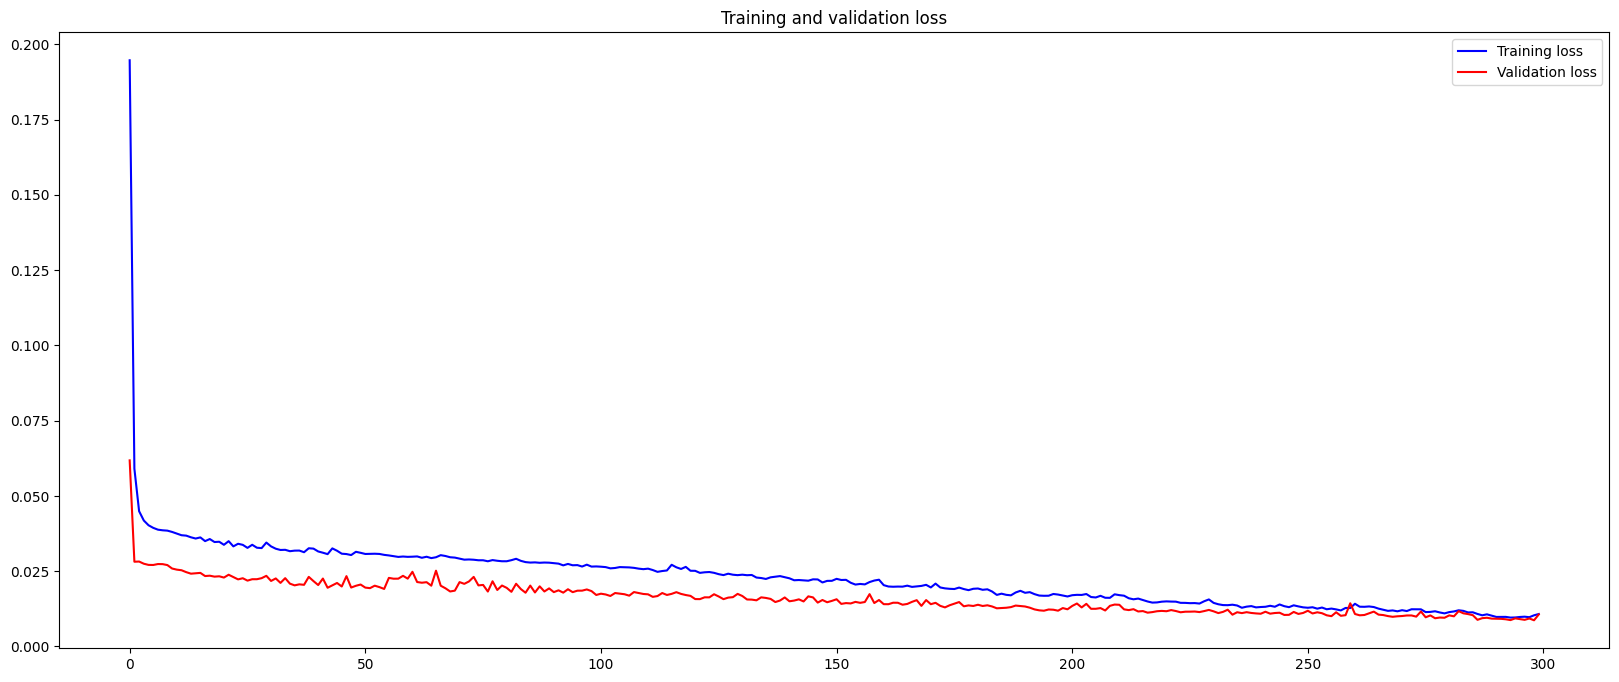

In [21]:
plot_loss(history_conv_lstm)

In [22]:
conv_lstm_model = tf.keras.models.load_model(
    "model_experiments/model_conv_lstm.keras")

model_preds = make_preds(conv_lstm_model, x_test_conv_lstm)
model_results = evaluate_preds(y_true=tf.squeeze(y_test),
                               y_pred=model_preds)

model_results

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step  


{'mae': np.float32(0.0070321863),
 'mse': np.float32(0.00011390366),
 'r2': 0.898215115070343}

#### Plot predictions

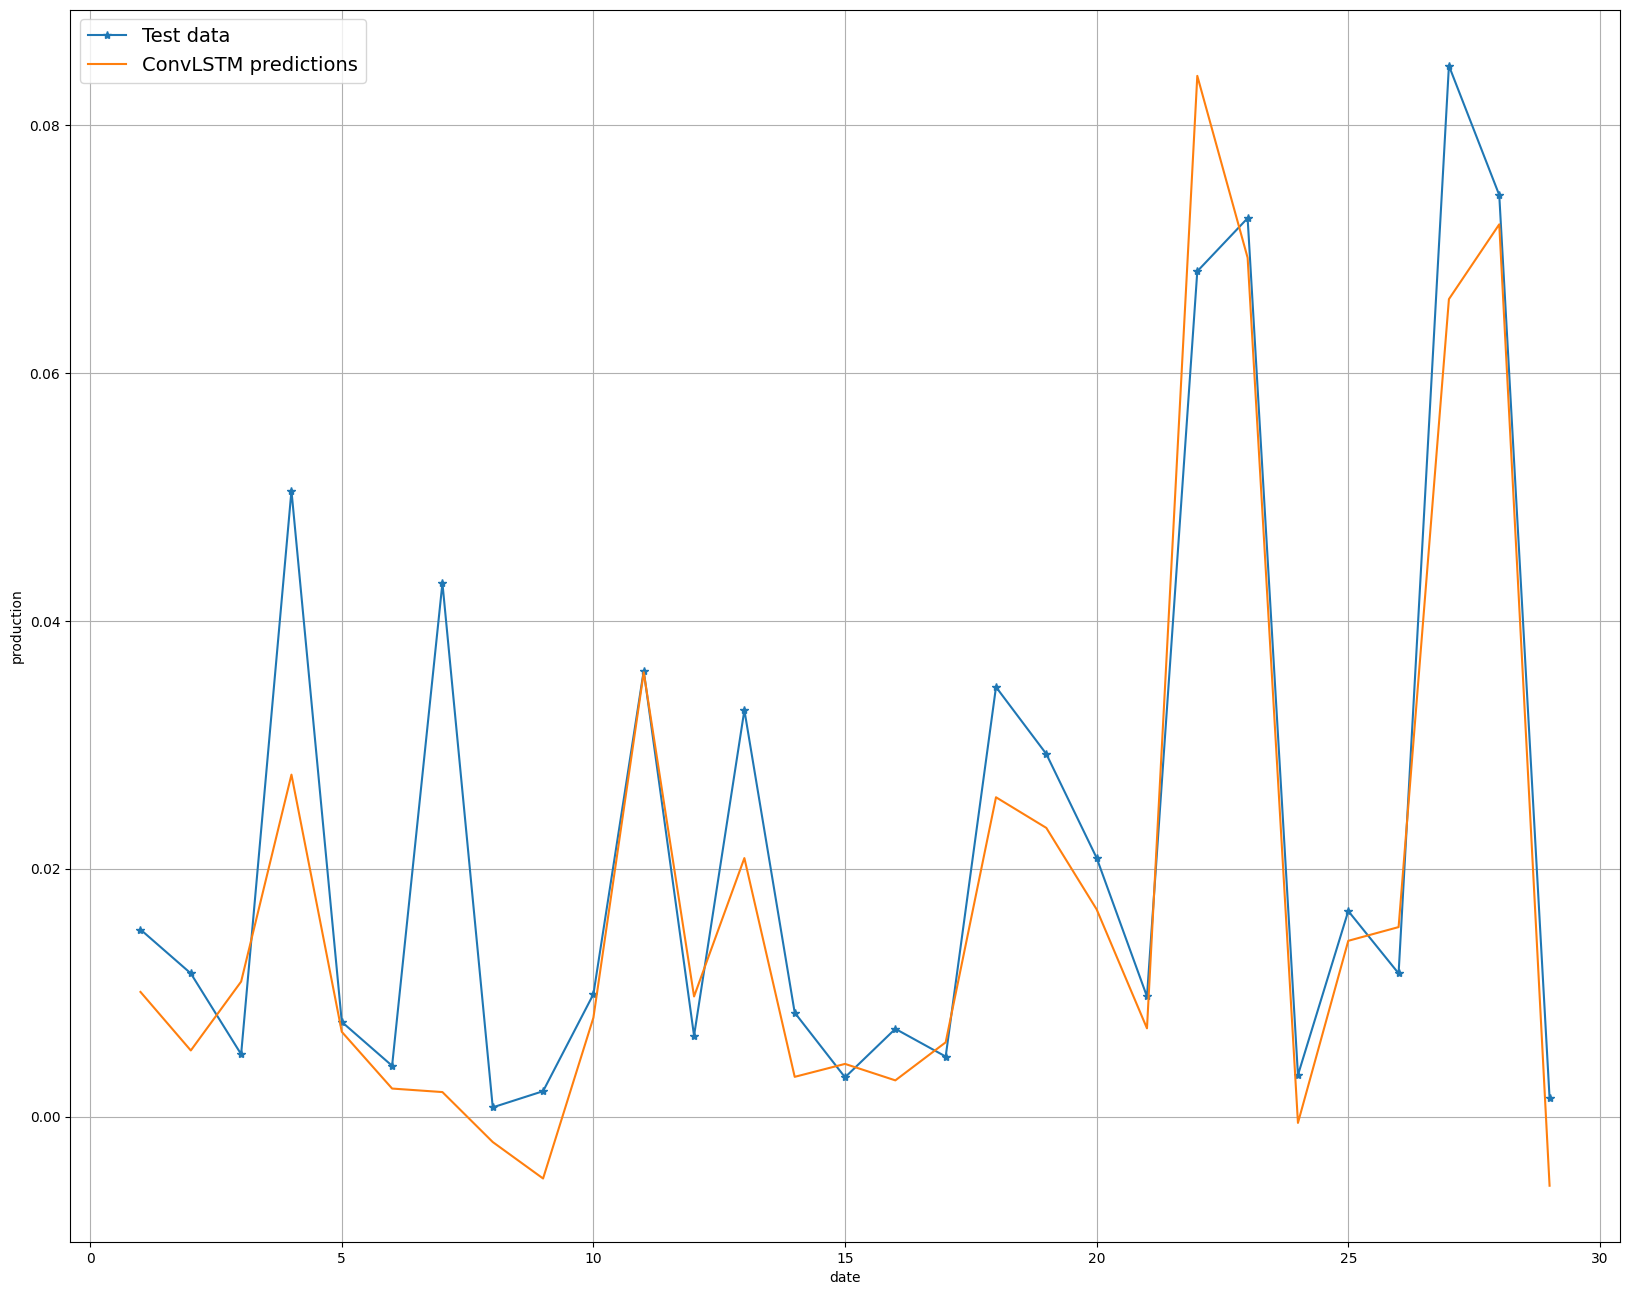

In [23]:
import numpy as np

start_offset = 1
end_offset = 30
plt.figure(figsize=(20, 16))


plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=y_test,
    start=start_offset,
    end=end_offset,
    format='-*',
    label="Test data"
)

plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=model_preds,
    start=start_offset,
    end=end_offset,
    format="-",
    label="ConvLSTM predictions"
)